In [1]:
import psi4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import linalg as splinalg
import time

## What factors limit the accuracy of the Hartree-Fock Method?

Hartree-Fock theory is successfully able to capture ca. 95% of the true energy (or our best approximation of it) for almost all systems. Most chemical predictions, however, require the remainder to be accurate. There are several essential, interrelated problems. 

First, the Fock operator is a single electron operator -- each electron moves in the mean-field of the others. The details of how the energy depends on where the many electrons are at any instant in time is lost in the mean-field approximation. This effect is called *electron correlation*. 

Second, HF theory is constructed around a Slater determinant, which provides the requisite antisymmetry with respect to the exchange of the positions of any two electrons. Closed-shell singlets are well described by this single Slater determinant, but many other electron configurations (triplets and even open-shell singlets) are not.  This second limitation of Hartree-Fock MO theory is its *single determinantal nature*.

A third problem that arises is not in the HF theory itself, but in our use of Gaussian type orbitals (GTOs). When point charges are near each other, the Coulomb potential becomes singular (either infinitely positive or infinitely negative). As a result, the electron wavefunction must have a discontinuous slope, a *cusp*. GTOs don't. This third set of requirements that GTOs do not meet are called *cusp conditions*.

### Pre-experiment Questions: Part One

1. Write the electron configuration you would expect for H$_2$ in terms of $\sigma$ and $\sigma^*$ orbitals in the ground-state. Is this state a singlet or triplet?

2. Individually: Write an excited-state electron configuration for H$_2$. 

3. As a team: Compare your answers and decide which excited-state configuration would be the lowest energy excited state (i.e. the first excited state). Is this state a singlet or triplet?

4. How do you expect the energy gap between the ground and first-excited states to change as a function of $r_{AB}$?

5. In the limit $r_{AB}\rightarrow\infty$, will you observe a difference in the energy of singlet and triplet states? Why or why not?

6. Based on the energy for a single, isolated H-atom in Eh, what energy should the H$_2$ calculation converge to as $r_{AB}$ increases?

### Experiment Part One

[0.4, 0.5, 0.75, 1, 1.5, 2, 4, 6]


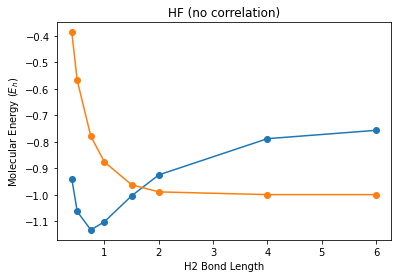

done
Energy at the minimum -1.132821931836138 Eh


In [2]:
psi4.core.clean()

# ==> Compute H2 singlet and triplet energy with Hartree-Fock using Psi4 <==

#method
method = 'SCF'

#minimal basis to start
#basis = 'sto-3g'

#bigger basis takes a few seconds
basis = 'cc-pvtz'

# set computation options
psi4.set_options({'basis': basis,
                  'reference': 'rohf'})
#psi4.set_options({'basis': basis})


# singlet H2 has a charge of 0, spin multiplicity of 1 (m_s=0)
h2_singlet = """
0 1
H 
H 1 {}
"""

# triplet H2 has a charge of 0, spin multiplicity of 3 (m_s=1)
h2_triplet = """
0 3
H 
H 1 {}
"""

rAB_list = [0.4, 0.5, 0.75, 1, 1.5, 2, 4, 6]
print(rAB_list)

def scan(geom,rAB,method='SCF'):
    e = ['']*len(rAB)
    count = -1
    for rAB in rAB_list:
        #print(rAB)
        count = count+1
        mol = psi4.geometry(geom.format(rAB))
        e[count] = psi4.energy(method,molecule=mol)
    return e

e_singlet = scan(h2_singlet,rAB_list,method)
#print(e_singlet)

e_triplet = scan(h2_triplet,rAB_list,method)
#print(e_triplet)

psi4.core.clean()

# Visualize energy profile
x = rAB_list
y1 = e_singlet
y2 = e_triplet
plt.title('HF (no correlation)')
plt.plot(x,y1,'o-',x,y2,'-o')
plt.xlabel('H2 Bond Length')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

print('done')

print(F'Energy at the minimum {np.min(e_singlet)} Eh')

**Based on the HF calculation above:**

What is the approximate H2 equilibrium bond length?

What is the ground state the spin multiplicity at this distance?

At long distances, what is the predicted lowest energy, ground state spin multiplicity?

Which state (singlet or triplet) converges to the correct energy?

Does the HF result match your expectations from above? Why or why not?


## Thinking about what went wrong

If we associate each electron with one nucleus or the other, describe four possible arrangements of the two electrons, $e_1$ and $e_2$, with the two nuclei, H$_A$ and H$_B$.

Assume all four possible arrangements are equally likely:

What is the probability of only electron 1 being associated with HA?

What is the probability of only electron 2 being associated with HA?

What is the probability that nucleus A has only one electron, $p(HA.)$?

What is the probability that nucleus A has two electrons, $p(HA:)$?

What is the probability that nucleus A has no electrons, $p(HA)$?

Identify the arrangements that become less likely as rAB -> infty? Explain your reasoning.


**Model 1: Joint probability**

Table Joint probability
       scenario 1 scenario 2
p(HA:) 1/4 0
p(HA.) 1/2 1
p(HA)  1/4 0
p(HB:) 1/4 0
p(HB.) 1/2 1
p(HB)  1/4 0

Is scenario 1 consistent with your answers above? 

What was the assumption that led to the probabilities in scenario 1?

In scenario 2, what is the likelihood of finding both electrons associated with HA?

If electron 1 is associated with HA, where is electron 2?

Describe the assumptions leading to the probabilities in scenario 2.

Which of these scenarios would you associate with a model representing the correlated motion of electrons?

Which scenario assumes the locations of the electrons to be correlated?

Which scenario would best match your expectations for an H2 molecule at bonding distances? At long distances?

What property of electrons is essential to include at long distances?

What is Hartree-Fock MO description of the singlet state missing that makes it poorly suited to describe H$_2$ at long distances?

## Essential (Static) electron correlation -- the need for more than one determinant
Let's use a simple model of H$_2$ in a minimal basis to see how additional determinants can add electron correlation.

The simplest MO description forms bonding and antibonding orbitals from 1s atomic orbitals. 

$$
\sigma = \sqrt{\frac{1}{2}}[\psi_{1sA} +\psi_{1sB}]
$$
and
$$
\sigma^* = \sqrt{\frac{1}{2}}[\psi_{1sA} -\psi_{1sB}]
$$

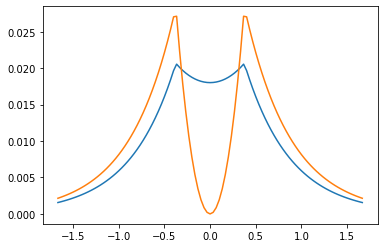

In [3]:
def psi1s(x,rN):
    # an unnormalized 1s orbital in 1D
    return np.exp(-np.abs(x-rN))

x = np.array([i for i in range(-50,51)])/30
#print(x)

#neglecting overlap
c_sigma = np.array([1,1])/np.sqrt(2)
c_sigma_star = np.array([1,-1])/np.sqrt(2)

def mo(x,rN_array,c):
    rA = rN_array[0]
    rB = rN_array[1]
    cA = c[0]
    cB=c[1]
    out = cA*psi1s(x,rA)+cB*psi1s(x,rB)
    norm = np.sqrt(np.sum(out**2))
    return out/norm

rN_array= np.array([-0.75/2, 0.75/2])

uh = mo(x,rN_array,c_sigma)
plt.plot(x,uh**2)

uh = mo(x,rN_array,c_sigma_star)
plt.plot(x,uh**2)

Where are the nuclei A and B? What is the bond length in this model? How is it related to the PES above?

Identify $\sigma$ and $\sigma^*$.

Do you see any nodes?

Where are the cusps in this wavefunction?

What would the wavefunctions look like if we had used GTOs?

The HF wavefunction, $|\Psi\rangle$, for the closed-shell singlet electron configuration, $\sigma^2\sigma^{*0}$,  is the Slater determinant

$$
|\Psi\rangle = 
\left|\begin{array}{cc}\sigma(1)\alpha(1) & \sigma(2)\alpha(2)\\
\sigma(1)\beta(1) & \sigma(2)\beta(2)
\end{array}
\right|
$$

Confirm that the Slater determinant expands to

$$
|\Psi\rangle = 
\sigma(1)\sigma(2)[\alpha(1)\beta(2) - \alpha(2)\beta(1)]
$$

**Information** This expression for $\Psi$ we will refer to as a *configuration state function* (CSF), because it is the function that expresses the particular electron configuration. In this case, the CSF can be expressed in a single determinant, but we will soon see other CSFs that cannot.

Let's look at the spatial part of the closed-shell singlet wavefunction.

$$
\Psi_1(r_1,r_2) = \sigma(1)\sigma(2)
$$

Text(0, 0.5, 'r2')

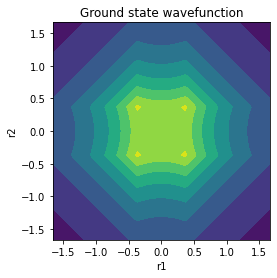

In [4]:
r1 = x
r2 = x
R1, R2 = np.meshgrid(r1,r2)


Psi1 = mo(R1,rN_array,c_sigma)*mo(R2,rN_array,c_sigma)

# plot the wavefunction 
plt.contourf(R1,R2,Psi1)
plt.title('Ground state wavefunction')
plt.axis('square')
plt.xlabel('r1')
plt.ylabel('r2')

Identify the value of $r_1$ where electron 1 is located on nucleus A.

Identify the value of $r_2$ where electron 2 is located on nucleus A.

In which quadrant of the graph is electron 1 on nucleus A and electron 2 is on nucleus A?

Which scenario above is most like this graph?

How are electrons treated in this representation, correlated or uncorrelated?

Other electron configurations are going to fix our problems. Let's look at them now.

There are two configurations with one electron excited (a single excitation) and one with both electrons excited (a double excitation).

The wavefunction of one of the single excitations is 
$$
\Psi_2(r_1,r_2) = \sigma(1)\sigma^*(2)
$$
What is the other, $\Psi_3(r_1,r_2)$?

What is the wavefunction of the double excitation, $\Psi_4(r_1,r_2)$?

Write a Slater determinant for the case of a double excitation. (We will return to the single excitations later.)

$$
|\Psi_4\rangle = 
\left|\begin{array}{cc}
\sigma^*(1)\alpha(1) & \sigma^*(2)\alpha(2)\\
\sigma^*(1)\beta(1) & \sigma^*(2)\beta(2)
\end{array}
\right|
$$

Complete the code below to plot the singly and doubly excited wavefunctions. 

(-1.6666666666666667,
 1.6666666666666667,
 -1.6666666666666667,
 1.6666666666666667)

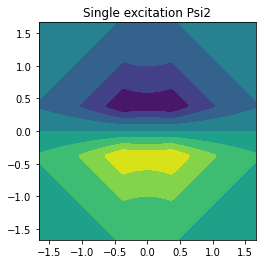

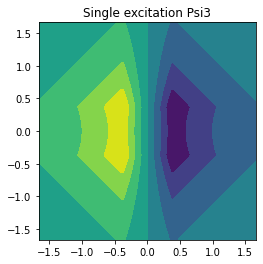

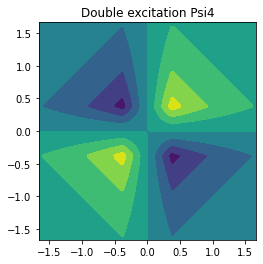

In [5]:
Psi2 = mo(R1,rN_array,c_sigma)*mo(R2,rN_array,c_sigma_star)
Psi3 = mo(R1,rN_array,c_sigma_star)*mo(R2,rN_array,c_sigma)
Psi4 = mo(R1,rN_array,c_sigma_star)*mo(R2,rN_array,c_sigma_star)

plt.figure()
plt.contourf(R1,R2,Psi2)
plt.title('Single excitation Psi2')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi3)
plt.title('Single excitation Psi3')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi4)
plt.title('Double excitation Psi4')
plt.axis('square')

Looking at the graphs above, identify the number of nodes in Psi2 through Psi4.

Now, let's mix the ground state and the doubly excited state by taking linear combinations of the determinants.

$$
\Psi_\pm = \Psi_1\pm\Psi_4
$$

and look at the resulting two-particle wavefunctions.

(-1.6666666666666667,
 1.6666666666666667,
 -1.6666666666666667,
 1.6666666666666667)

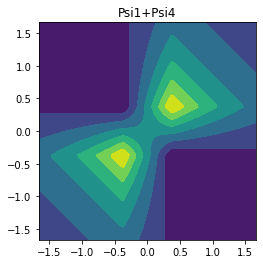

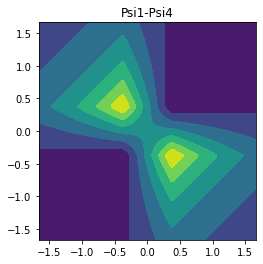

In [6]:

plt.figure()
plt.contourf(R1,R2,Psi1+Psi4)
plt.title('Psi1+Psi4')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi1-Psi4)
plt.title('Psi1-Psi4')
plt.axis('square')





In $\Psi_+$, if electron 1 is on nucleus A, where is electron 2 most likely to be found?

In $\Psi_-$, if electron 1 is on nucleus A, where is electron 2 most likely to be found?

How many nodes are in these wavefunctions?

Which wavefunction, $\Psi_+$ or $\Psi_-$, best reproduces scenario 2 above?

What would the other wavefunction represent?

In your own words, explain how adding multiple determinants can introduce electron correlation to the HF wavefunction.



# Configuration Interaction Adds More Determinants
Configuration interaction (CI) calculations treat the wavefunction as a combination of multiple (sometimes very many!) determinants. For H$_2$ in a minimal basis, only single and double excitations are possible because there are only two electrons. CI with single and double excitations is called CISD.

A wavefunction is constructed as a linear combination of determinants, and the variational principle is again used to find the lowest energy.

Mixing configurations of the ground state (Hartree-Fock) single determinant with the doubly excited $\Psi_4$ is called CI doubles, or CID.
$$
\Psi_\textrm{CI} = c_1\Psi_1 + c_2\Psi_4
$$
Additional determinants at the level of singles gives CISD. Triples makes CISDT, quadruples are CISDTQ, and so forth.

Could say something about the orders -- singles don't mix with the ground state by symmetry (I htink the number of nodes argument above should suffice to motivate or maybe prove this) where the doubles can. The singles can mix with the doubles, though. 

Something about counting the number of possibilities?

In [ ]:
method = 'cisd'
psi4.core.set_output_file('output.dat', False)


e_singlet = scan(h2_singlet,rAB_list,method)
#print(e_singlet)

e_triplet = scan(h2_triplet,rAB_list,method)
#print(e_triplet)


# Visualize energy profile
x = rAB_list
y1 = e_singlet
y2 = e_triplet
plt.title('CISD (correlation)')
plt.plot(x,y1,'o-',x,y2,'-o')
plt.xlabel('H2 Bond Length')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

print('done')
print(F'Energy at the minimum {np.min(e_singlet)} Eh')

Question: What is the energy difference between singlet and triplet states at rAB-> infinity? 

Which is better description of the dissociation of H$_2$, CISD or HF?

What is the energy at $r_{AB}\rightarrow\infty$? How does that compare with the exact result?

Look at the CISD energy of the ground state and compare to the HF energy? Which energy is more correct? Why?

What is the energy difference between HF and CISD in units of kcal/mol? (Hint: 1 Ha = 627.509 kcal mol-1.)

Which is better description of the bonding region of H$_2$, CISD or HF?

**Information** Any time multiple electron configurations become close in energy, HF is in trouble because it is built on a single determinant. 


## The correlation that HF gets correct -- exchange correlation

Let's return to the singly excited CSFs considering both space and spin.

If we have two MOs, each occupied by one electron, and each electron with two spins, how many ways of arranging the electrons are there?

The total wavefunction must be antisymmetric with respect to exchange. Because the wavefunction factorizes in to space and spin, either the spatial or spin parts of the wavefunction must be antisymmetric. If the spatial part is symmetric, the spin part must be antisymmetric and vice versa. The resulting combinations are a singlet and a three triplet states.

The open-shell singlet is
$$
^0\Psi = (\sigma(1)\sigma^*(2)+\sigma^*(1)\sigma(2))[\alpha(1)\beta(2)-\alpha(2)\beta(1)] 
$$
The three triplets are
\begin{align}
^3_1\Psi &= (\sigma(1)\sigma^*(2)-\sigma^*(1)\sigma(2))\alpha(1)\alpha(2)\\ 
^3_0\Psi &= (\sigma(1)\sigma^*(2)-\sigma^*(1)\sigma(2))[\alpha(1)\beta(2)+\alpha(2)\beta(1)] \\
^3_{-1}\Psi &= (\sigma(1)\sigma^*(2)-\sigma^*(1)\sigma(2))\beta(1)\beta(2)
\end{align}




In [ ]:
Psi_OSS = mo(R1,rN_array,c_sigma)*mo(R2,rN_array,c_sigma_star)+mo(R1,rN_array,c_sigma_star)*mo(R2,rN_array,c_sigma)
Psi_triplet = mo(R1,rN_array,c_sigma)*mo(R2,rN_array,c_sigma_star)-mo(R1,rN_array,c_sigma_star)*mo(R2,rN_array,c_sigma)


plt.figure()
plt.contourf(R1,R2,Psi_OSS)
plt.title('Psi_OSS')
plt.axis('square')

plt.figure()
plt.contourf(R1,R2,Psi_triplet)
plt.title('Psi_triplet')
plt.axis('square')




Which of the two wavefunctions localizes the electrons on opposite nuclei? 

Which puts them on the same nuclei?

How many nodes are there in these wavefunctions?

In the $^3_1\Psi$, the cancellation of electrons is called a "Fermi hole." Because, for a triplet, the spins are identical, the spatial part of the wavefunction must have the minus sign, and the electrons cannot be in the same location. The triplet energy is correct because of this cancellation.

Notice that the open-shell singlet tends to pair the electrons, in what is called a "Fermi heap." Propose a physical interpretation of the open-shell singlet state.





## Correlation in the bonding region
HF failed spectacularly to describe the dissociation of H$_2$. It is much better in the bonding regions, but chemical accuracy often requires incorporating additional electron correlation effects. 


TO DO: Propose some molecules and look at changes in the bonding properties?


## Other approaches to adding electron correlation
### CI S D T Q H ... Full CI
Systematic improvements but the number of determinants grows really fast, so this is a mess.

### MP2
It involves the double excitations! 

Nonvariational nature means it tends to overestimate corrections.

### Coupled-Cluster
A way to get higher orders of single- and double-excitation operators...

It is not variational but seems very close to the variational results for reasons that are beyond me. 

## Dispersion interactions are electron correlation effects



In [37]:

# singlet H2 has a charge of 0, spin multiplicity of 1 (m_s=0)
he_dimer = """
0 1
He 
He 1 {}
"""

be_dimer = """
0 1
Be 
Be 1 {}
"""

ar_dimer = """
0 1
Ar 
Ar 1 {}
"""


# for He
rAB_list = [2.75, 2.87, 3, 3.5, 4, 10]

# for Ar
rAB_list = [3.5, 3.75, 4, 4.5, 5, 6, 10]

print(rAB_list)

def scan(geom,rAB,method='SCF',basis='sto-3g'):
    t_start = time.perf_counter()
    
    # set computation options
    psi4.set_options({'basis': basis,
                  'reference': 'rohf'})

    e = ['']*len(rAB)
    count = -1
    for rAB in rAB_list:
        #print(rAB)
        count = count+1
        mol = psi4.geometry(geom.format(rAB))
        e[count] = psi4.energy(method,molecule=mol)
        
    t_diff = time.perf_counter() - t_start
    #print(F'Energy at the minimum {np.min(e)} Eh located at {rAB_list[np.argmin(e)]} a0')
    r_min = rAB_list[np.argmin(e)]
    e_min = np.min(e)
    de = e_min - e[-1]
    print(F'\nr_min/a0\tE_min/a.u.\tdE/a.u.')
    #print(F'{r_min}\t{e_min}\t{de}')
    print('%8.5f\t%8.3f\t%8.6f' % (r_min, e_min, de))
    print(F'\n{method} time elapsed {t_diff} s')
    psi4.core.clean()
    return e

def listdiff(e,ind=-1):
    return list(np.array(e)-np.array(e[ind]))

mol = ar_dimer

basis = 'cc-pVTZ'
#basis = 'cc-pVDZ'

method = 'SCF'
t_start = time.perf_counter()
e_hf = scan(mol,rAB_list,method,basis)
#print(e_hf)

method = 'MP2' #1.5 times slower
e_mp2 = scan(mol,rAB_list,method,basis)
#print(e_mp2)

method = 'CCSD' #10 times slower
e_ccsd = scan(mol,rAB_list,method,basis)
#print(e_ccsd)

method = 'CISD' #100 times slower
e_cisd = scan(mol,rAB_list,method,basis)
#print(e_cisd)


# Visualize energy profile
x = rAB_list
#y1 = list(np.array(e_hf)-np.array(e_hf[-1]))
y1 = listdiff(e_hf)
y2 = listdiff(e_mp2)
y3 = listdiff(e_ccsd)
y4 = listdiff(e_cisd)
plt.title('PES')
plt.plot(x,y1,'o-')
plt.plot(x,y2,'-o')
plt.plot(x,y3,'-o')
plt.plot(x,y4,'-o')
plt.xlabel('rAB')
plt.ylabel('Molecular Energy ($E_h$)')
plt.legend(('SCF','MP2','CCSD','CISD'))
plt.show()

print('done')



[3.5, 3.75, 4, 4.5, 5, 6, 10]

r_min/a0	E_min/a.u.	dE/a.u.
 5.00000	-1053.626	-0.000007

SCF time elapsed 6.06800469000018 s

r_min/a0	E_min/a.u.	dE/a.u.
 4.00000	-1054.102	-0.000257

MP2 time elapsed 7.733313002000159 s

r_min/a0	E_min/a.u.	dE/a.u.
 4.00000	-1054.133	-0.000165

CCSD time elapsed 51.297695928000394 s

r_min/a0	E_min/a.u.	dE/a.u.
 4.00000	-1054.086	-0.000120

CISD time elapsed 390.76414373199987 s


NameError: name 'e_cisd' is not defined

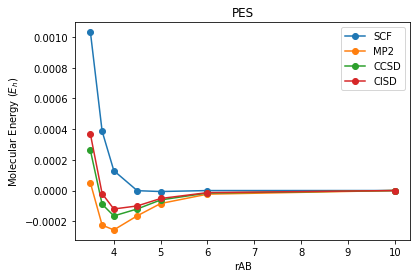

In [40]:
e_cisd = e_ccid


# Visualize energy profile
x = rAB_list
#y1 = list(np.array(e_hf)-np.array(e_hf[-1]))
y1 = listdiff(e_hf)
y2 = listdiff(e_mp2)
y3 = listdiff(e_ccsd)
y4 = listdiff(e_cisd)
plt.title('PES')
plt.plot(x,y1,'o-')
plt.plot(x,y2,'-o')
plt.plot(x,y3,'-o')
plt.plot(x,y4,'-o')
plt.xlabel('rAB')
plt.ylabel('Molecular Energy ($E_h$)')
plt.legend(('SCF','MP2','CCSD','CISD'))
plt.show()




# Trying to plot the wavefunction!!!! ARGH!

In [ ]:
help(wfn)

In [ ]:
help( psi4.core.Wavefunction)

In [ ]:
h2_singlet = """
0 1
H 
H 1 0.75
"""
#minimal basis
basis='sto-3g'

#bigger basis takes a few seconds
#basis = 'cc-pvtz'

# set computation options
psi4.set_options({'basis': basis,
                  'reference': 'rohf'})

mol = psi4.geometry(h2_singlet)
wfn=psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))

ndocc = wfn.nalpha()
nbf = wfn.basisset().nbf()

print(F'Number of occupied orbitals: {ndocc}')
print(F'Number of basis functions: {nbf}') 


In [ ]:
# Construct a molecular integrals object
mints = psi4.core.MintsHelper(wfn.basisset())

# Overlap matrix as a psi4 Matrix object
S_matrix = mints.ao_overlap()

# Overlap matrix converted into an ndarray
S = np.asarray(S_matrix) 

print(F'Shape of S is {S.shape}')

In [ ]:
e,wfn_out=psi4.energy('SCF',molecule=mol,return_wfn='true')
print(e)
#wfn coeffs
Ca = wfn_out.Ca().to_array(dense='true')
Cb = wfn_out.Cb().to_array(dense='true')
#density matrices
Da = wfn_out.Da().to_array(dense='true')
Db = wfn_out.Db().to_array(dense='true')
#eigenvalues
epsilon_a = wfn_out.epsilon_a().to_array(dense='true')
epsilon_b = wfn_out.epsilon_b().to_array(dense='true')
aotoso = wfn_out.aotoso().to_array(dense='true')

print('coeffs')
print(Ca)
print(Cb)
print('densities')
print(Da)
print(Db)
print('eigenvalues')
print(epsilon_a)
print(epsilon_b)

#not sure
print(aotoso)
print(aotoso.dot(Ca))

#
S = wfn_out.S().to_array(dense='true')
print()

print(F'S=\n{S}')
A = splinalg.sqrtm(np.linalg.inv(S))
C=A.dot(Ca)
print(C)

# I think what I need is a way to "simply" evaluate the wavefunction amplitude as a function of r1 and r2. How can I do that?
#If I can do that I can plot the wavefunction amplitude (or square) on a grid over A and B

In [ ]:
help(wfn)

In [ ]:
help(psi4.core.MintsHelper)

In [ ]:
help(psi4.core)

In [ ]:
wfn.p

In [ ]:
help(psi4.core.MintsHelper)

In [ ]:
mints = psi4.core.MintsHelper(wfn)
np.asarray(mints.ao_overlap())

In [ ]:

help(psi4.energy)

In [ ]:
help(psi4.core.Matrix)

In [ ]:
help(psi4.core.BasisSet
    )

In [ ]:
help(psi4.core.MolecularGrid)

In [ ]:
help(psi4.cubeprop)

In [ ]:
help()

In [ ]:
help(wfn)